In [92]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
from scipy import fftpack as spfft # for computing spectra
import librosa
import resampy
from subprocess import call

%matplotlib inline

# Set plot fontsize
matplotlib.rcParams.update({'font.size': 22})

Direct sonification is simply the process of changing the time scale of a signal to transpose it to the audible range. The data should therefore have similarities with sound waves in air, that is:

 - oscillations around an average value (better if this value is 0), a.k.a "stationary" data. 
 - not a vast range of amplitudes in the thing of interest
 - enough cycles to produce sound at the new frequency. 

We take the example of seismic data... but they could be many other things, e.g.:

[planetary:] 

 - ocean waves, tidal data
 - electro-magnetic waves (solar winds?)
 - gravitational waves
 - planetary orbital positions
 
[biological:] 

 - waves created by in blood circulation
 - ekg waves?
 
[sociological:] 
 - ? 

# EXAMPLE 1: a large earthquake 


## 1. Get the data (and in to python):

In [93]:
DirIn = '../2_data/'
DirOut = '../3_output/'
# This is the Tohoku earthquake (2011), recorded by a seimic station located in Central USA
                        #   close       medium       far
FileNameIn = 'P39A.BHZ' #  'MAJO.BHZ', 'P39A.BHZ', 'TRQA.BHZ' Note that this data has been pre-processed (instrument response removal)
eqdir = 'M9.1' # 'M9.1' for Tohoku main shock and 'M7.3' for foreshock
sr = 20 # Datatype BHZ is sampled at 20 Hz
# (this info you need to get with the data!)

data = np.loadtxt(DirIn + eqdir +'/'+ FileNameIn)
duration = len(data)/sr
print('We have ' + str(int(duration)) + ' seconds of data!')
print('... which is ' + str(int(duration/3600)) + ' hours of data!')

# make time vectors for plotting purposes only
t = np.arange(0,duration,1./sr) # in seconds
t_hours = np.arange(0,duration/3600,1./sr/3600) # in hours

We have 25200 seconds of data!
... which is 7 hours of data!


In [94]:
# Compute the spectrum
Nfft = len(data)
f = np.arange(0,sr/2,sr/Nfft)
S = spfft.fft(data,Nfft); S = S[:int(Nfft/2)]
print('Frequency content ranges from ' + str(f[0]) + ' to ' + str(round(f[-1],3)) + ' Hz...')
print('Frequency content ranges from [log10] ' + str(np.log10(f[1])) + ' to ' + str(np.log10(f[-1])) + ' Hz...')

Frequency content ranges from 0.0 to 10.0 Hz...
Frequency content ranges from [log10] -4.40140054078 to 0.999998276606 Hz...


(-0.4999980158730159,
 10.499958333333334,
 -189.38381774231229,
 26.69441185165141)

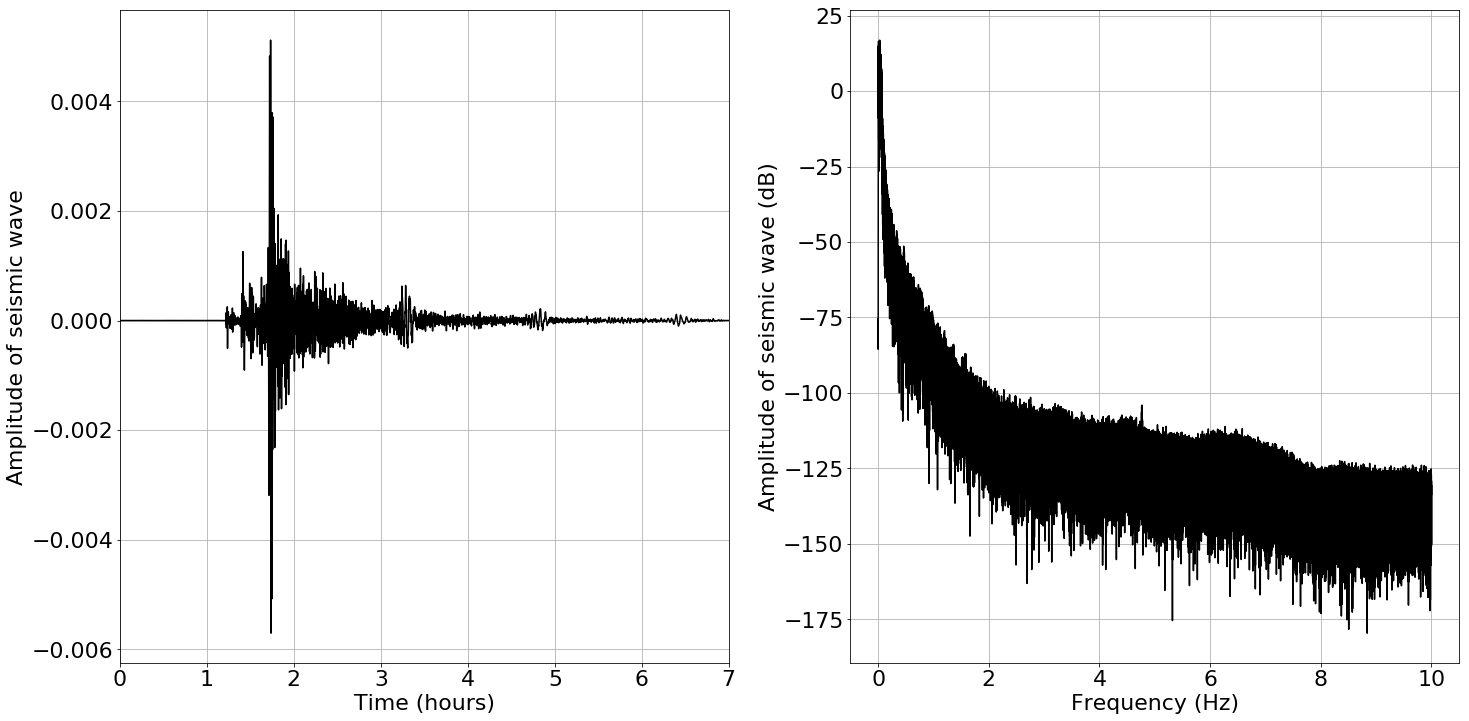

In [95]:
plt.figure(figsize=(12*2,6*2))
plt.subplot(1,2,1)
plt.plot(t_hours,data,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave')
plt.grid()
plt.xlim([0,duration/3600])
plt.subplot(1,2,2)
plt.plot(f,20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()
plt.axis()

# NOW MAKE SOUND !

In [96]:
###### some useful prerequisites...

# 1) force the signal's mean value to be zero (how to kill your loudspeakers...)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers...)
# a simple way is to normalize the data according to its maximum amplitude value
# data = data/np.amax(data) # This is dangerous, peak values can be negative, too
data_n = data/np.amax(np.absolute(data))

/Users/russell/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


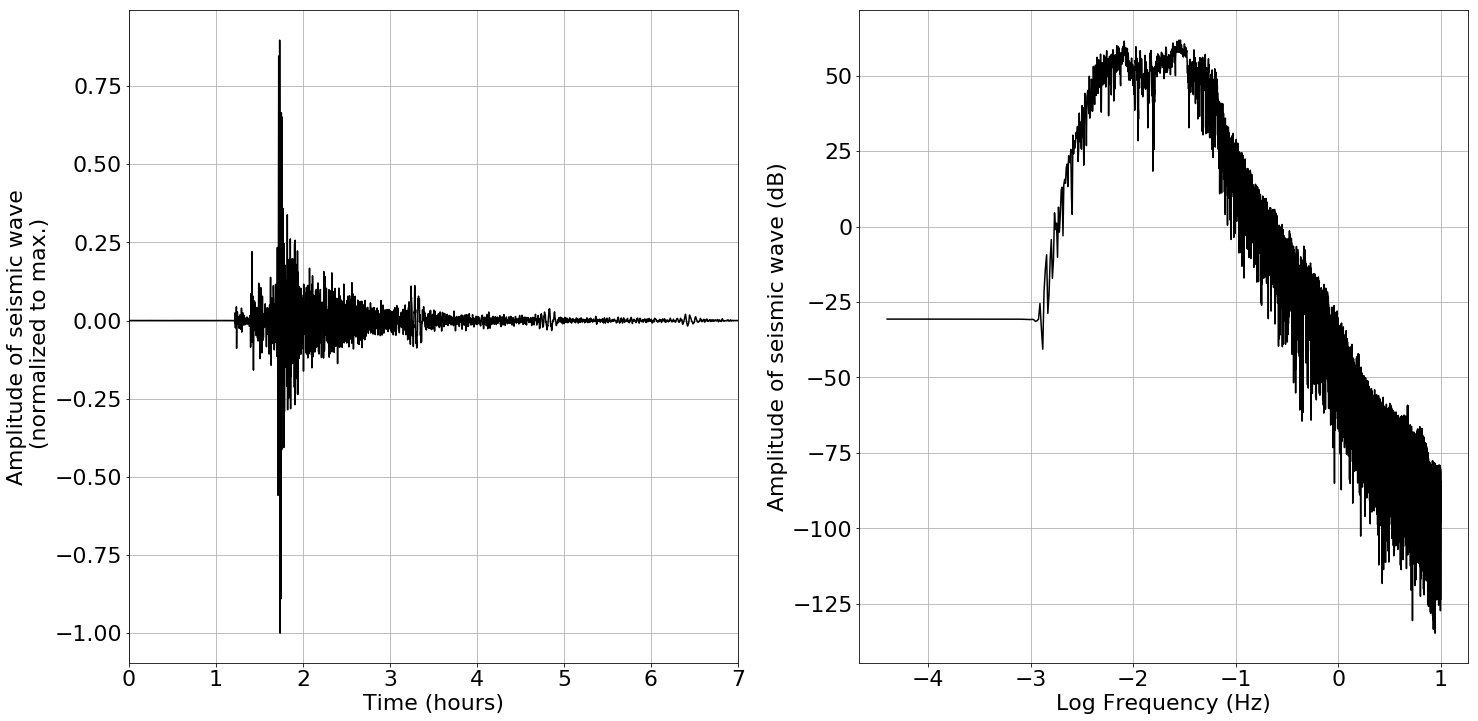

In [97]:
# plot again
S = spfft.fft(data_n,Nfft); S = S[:int(Nfft/2)]

plt.figure(figsize=(12*2,6*2))
plt.subplot(1,2,1)
plt.plot(t_hours,data_n,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave\n (normalized to max.)')
plt.grid()
plt.xlim([0,duration/3600])
plt.subplot(1,2,2)
plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Log Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()

In [98]:
# For the free oscillations, we had a specific frequency that we wanted to shift to another one
# Here we can define a target duration instead

OriginalDuration = duration
TargetDuration = 5.0 # Try playing with this number! What happens to the sound if you make it smaller? Larger?
print('The data is ' + str(int(OriginalDuration)) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(int(SpeedFactor)))

# (here we are speeding up the playback because the original content is infrasonic / 
# There are cases where we want to do the opposite, e.g. solar magnetic waves, acoustic emissions during rock microcracking...)
# compute the corresponding shift in frequency
# show the result with subplots original data VS. sonified data 
#      (time series / spectrum / spectrogram = no change except in the time scale)

OutFileName = eqdir + '_' + FileNameIn[:-4] + '_sonified_'+ str(TargetDuration) + 's.wav'

The data is 25200-s long
Let's make a 5.0-second long sound!
This corresponds to a speed factor of: 5040


Text(0.5,1,'New Seismogram (audible)')

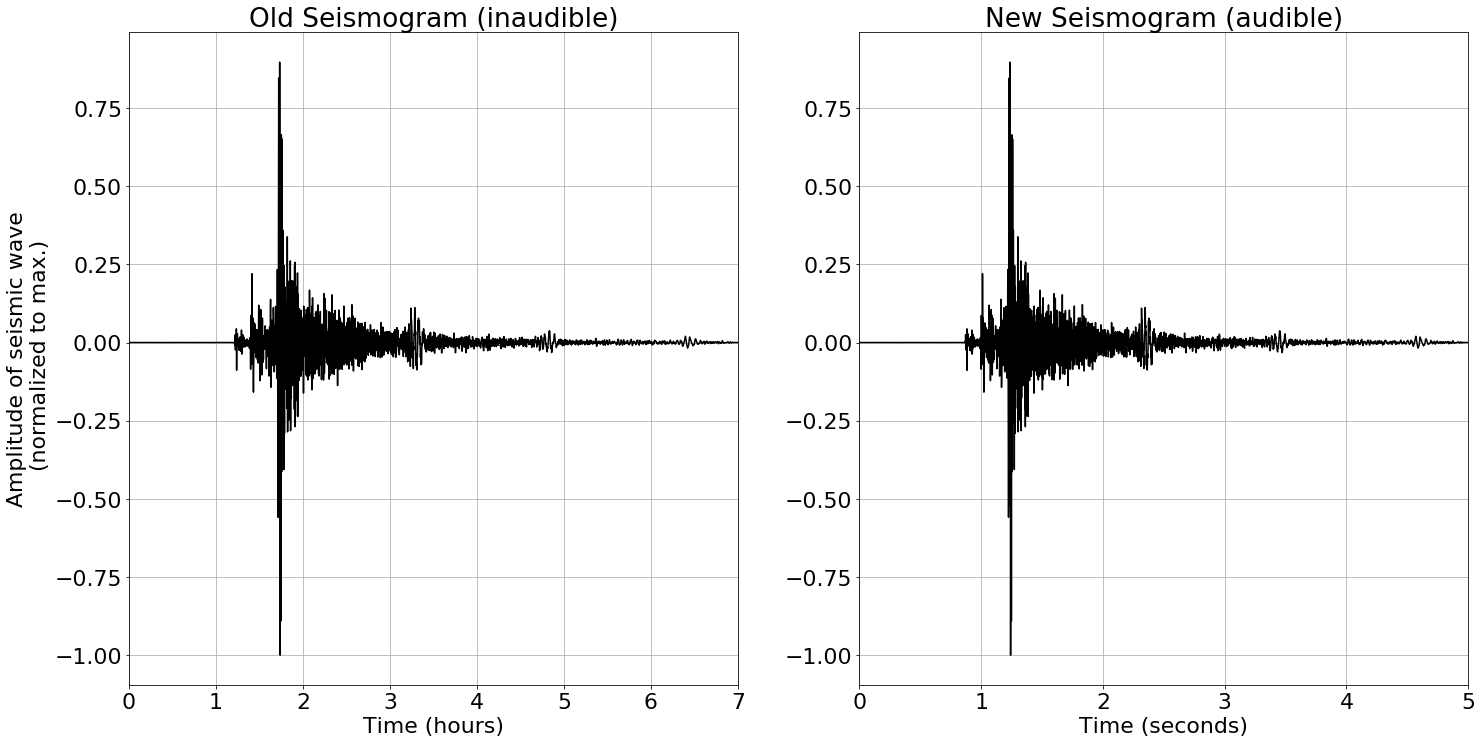

In [99]:
# Original vs. Sonified Data
plt.figure(figsize=(12*2,6*2))
plt.subplot(1,2,1)
plt.plot(t_hours,data_n,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave\n (normalized to max.)')
plt.grid()
plt.xlim([0,OriginalDuration/3600])
plt.title('Old Seismogram (inaudible)')

plt.subplot(1,2,2)
plt.plot(t_hours*3600/SpeedFactor,data_n,'k') 
plt.xlabel('Time (seconds)')
plt.grid()
plt.xlim([0,TargetDuration])
plt.title('New Seismogram (audible)')

# The difference is only in the time scale. We compress 14 hours into 12 seconds

In [100]:
# So, set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(sr*SpeedFactor)
#sr_resample = 44100

librosa.output.write_wav(DirOut + OutFileName, data_n, sr_sound, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary 
# to resample your sound.
#dataOrig, srOrig = librosa.core.load(DirOut + OutFileName, sr=sr_sound)
#data_rs = resampy.resample(dataOrig, srOrig, sr_resample)
#librosa.output.write_wav(DirOut + OutFileName, data_rs, sr_resample, norm=False)